In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 4.0 이상 버전 필요
!pip install transformers

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import transformers
import glob
import os
import csv

# MELD Dataset

## Dataset Load

MELD GitHub : https://github.com/declare-lab/MELD.git

In [4]:
if not os.path.exists('MELD'):
    !git clone https://github.com/declare-lab/MELD.git

Cloning into 'MELD'...
remote: Enumerating objects: 487, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 487 (delta 6), reused 1 (delta 0), pack-reused 475
Receiving objects: 100% (487/487), 8.12 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (254/254), done.


In [5]:
data_path = './MELD/data/MELD/*.csv'
data_path_list = glob.glob(data_path)
print(data_path_list)

['./MELD/data/MELD/dev_sent_emo.csv', './MELD/data/MELD/test_sent_emo.csv', './MELD/data/MELD/train_sent_emo.csv']


## 데이터 확인

In [6]:
# data 세션 분리

def data_split(session):
    final_data = []
    split_session = []

    for line in session:
        split_session.append(line)
        final_data.append(split_session[:])

    return final_data

In [7]:
for data_path in data_path_list:
    f = open(data_path)
    rdr = csv.reader(f)
    for i in rdr:
        print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['5262', 'I think that a person should know where they come from.', 'Phoebe Sr', 'neutral', 'neutral', '530', '19', '3', '25', '00:20:00,991', '00:20:03,951']
['5263', 'Wh-which is why I ah,  ahh,  okay.', 'Phoebe Sr', 'neutral', 'neutral', '530', '20', '3', '25', '00:20:04,620', '00:20:14,629']
['5264', 'I’m your mother.', 'Phoebe Sr', 'neutral', 'neutral', '530', '21', '3', '25', '00:20:15,672', '00:20:17,340']
['5265', 'Heh?', 'Phoebe', 'surprise', 'negative', '530', '22', '3', '25', '00:20:20,177', '00:20:21,677']
['5266', "Y'know I wanted to tell you yesterday, but I just, I kinda felt all floopy, and...", 'Phoebe Sr', 'sadness', 'negative', '530', '23', '3', '25', '00:20:22,512', '00:20:27,642']
['5267', 'What’s happening to your accent?', 'A Student', 'surprise', 'negative', '531', '0', '6', '4', '00:20:01,742', '00:20:04,327']
['5268', 'Come again?', 'Ross', 'surprise', 'negative', '531', '1', '6', '4', '0:20:07,164', '0:20:07,976']
['5269', 

In [8]:
for data_path in data_path_list:
    f = open(data_path)
    rdr = csv.reader(f)

    session = []
    session_dataset = []
    speaker_set = []

    pre_sess = 'start'

    for i, line in enumerate(rdr):
        if i == 0:
            header = line
            utt_idx = header.index('Utterance')
            speaker_idx = header.index('Speaker')
            emo_idx = header.index('Emotion')
            sess_idx = header.index('Sentiment')
        else:
            utt = line[utt_idx]
            speaker = line[speaker_idx]
            emotion = line[emo_idx]
            sess = line[sess_idx]

            if speaker in speaker_set:
                uniq_speaker = speaker_set.index(speaker)
            else:
                speaker_set.append(speaker)
                uniq_speaker = speaker_set.index(speaker)

            if pre_sess == 'start' or sess == pre_sess:
                session.append([uniq_speaker, utt, emotion])
            else:
                session_dataset += data_split(session)

                session = [[uniq_speaker, utt, emotion]]
                speaker_set = []
            pre_sess = sess

    session_dataset += data_split(session)
    f.close()

In [9]:
session_dataset[3]

[[0,
  'also I was the point person on my company’s transition from the KL-5 to GR-6 system.',
  'neutral'],
 [1, 'You must’ve had your hands full.', 'neutral'],
 [0, 'That I did. That I did.', 'neutral'],
 [1, 'So let’s talk a little bit about your duties.', 'neutral']]

In [10]:
for i in session_dataset[:10]:
    print(i)

[[0, 'also I was the point person on my company’s transition from the KL-5 to GR-6 system.', 'neutral']]
[[0, 'also I was the point person on my company’s transition from the KL-5 to GR-6 system.', 'neutral'], [1, 'You must’ve had your hands full.', 'neutral']]
[[0, 'also I was the point person on my company’s transition from the KL-5 to GR-6 system.', 'neutral'], [1, 'You must’ve had your hands full.', 'neutral'], [0, 'That I did. That I did.', 'neutral']]
[[0, 'also I was the point person on my company’s transition from the KL-5 to GR-6 system.', 'neutral'], [1, 'You must’ve had your hands full.', 'neutral'], [0, 'That I did. That I did.', 'neutral'], [1, 'So let’s talk a little bit about your duties.', 'neutral']]
[[0, 'My duties?  All right.', 'surprise']]
[[0, 'Now you’ll be heading a whole division, so you’ll have a lot of duties.', 'neutral']]
[[0, 'Now you’ll be heading a whole division, so you’ll have a lot of duties.', 'neutral'], [0, 'I see.', 'neutral']]
[[0, 'Now you’ll be

## data set 구축

In [11]:
class MyDataset(Dataset):
    def __init__(self, data_path):
        f = open(data_path, 'r')
        rdr = csv.reader(f)

        emoSet = set()

        """ 세션 데이터 저장할 것"""
        self.session_dataset = []
        session = []
        speaker_set = []

        """ 실제 데이터 저장 방식 """
        pre_sess = 'start'
        for i, line in enumerate(rdr):
            if i == 0:
                """ 저장할 데이터들 index 확인 """
                header  = line
                utt_idx = header.index('Utterance')
                speaker_idx = header.index('Speaker')
                emo_idx = header.index('Emotion')
                sess_idx = header.index('Dialogue_ID')
            else:
                utt = line[utt_idx]
                speaker = line[speaker_idx]
                emotion = line[emo_idx]
                sess = line[sess_idx]

                """ 유니크한 스피커로 바꾸기 """
                if speaker in speaker_set:
                    uniq_speaker = speaker_set.index(speaker)
                else:
                    speaker_set.append(speaker)
                    uniq_speaker = speaker_set.index(speaker)

                if pre_sess == 'start' or sess == pre_sess:
                    session.append([uniq_speaker, utt, emotion])
                else:
                    """ 세션 데이터 저장 """
                    self.session_dataset += data_split(session)

                    session = [[uniq_speaker, utt, emotion]]
                    speaker_set = []
                    emoSet.add(emotion)

                pre_sess = sess

        """ 마지막 세션 저장 """
        self.session_dataset += data_split(session)

        """ 추가 """
        # self.emoList = sorted(emoSet) # 항상 같은 레이블 순서를 유지하기 위해
        self.emoList = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        f.close()

    def __len__(self):
        return len(self.session_dataset)

    def __getitem__(self, idx):
        return self.session_dataset[idx]

    def collate_fn(self, sessions): # 배치
        '''
            input:
                data: [(session1), (session2), ... ]
            return:
                batch_input_tokens_pad: (B, L) padded
                batch_labels: (B)
        '''
        batch_input_token = []
        for session in sessions:
            input_token = ""
            for line in session:
                speaker, utt, emotion = line
                input_token += utt
            batch_input_token.append(input_token)

        return batch_input_token

In [12]:
dev_dataset = MyDataset('./MELD/data/MELD/dev_sent_emo.csv')

In [13]:
dev_dataset[:5]

[[[0, 'Oh my God, he’s lost it. He’s totally lost it.', 'sadness']],
 [[0, 'Oh my God, he’s lost it. He’s totally lost it.', 'sadness'],
  [1, 'What?', 'surprise']],
 [[2,
   'Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
   'neutral']],
 [[2,
   'Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
   'neutral'],
  [0, 'You’re a genius!', 'joy']],
 [[2,
   'Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
   'neutral'],
  [0, 'You’re a genius!', 'joy'],
  [1, 'Aww, man, now we won’t be bank buddies!', 'sadness']]]

In [14]:
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

In [15]:
for i, data in enumerate(dev_dataloader):
    print(i)
    print(data)
    break

0
['Oh my God, he’s lost it. He’s totally lost it.']


In [16]:
dev_dataloader = DataLoader(dev_dataset, batch_size=3, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

for i, data in enumerate(dev_dataloader):
    print(i)
    print(data[0])
    print(data[1])
    print(data[2])
    break

0
Oh my God, he’s lost it. He’s totally lost it.
Oh my God, he’s lost it. He’s totally lost it.What?
Or! Or, we could go to the bank, close our accounts and cut them off at the source.


## 허깅페이스 RobertaTokenizer
https://github.com/thunlp/PLMpapers

In [17]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [18]:
print(tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token)
print(tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id)

<s> </s> <pad>
0 2 1


In [21]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_added_tokens_decoder',
 '_added_tokens_encoder',
 '_additional_special_tokens',
 '_auto_class',
 '_batch_encode_plus',
 '_batch_prepare_for_model',
 '_bos_token',
 '_call_one',
 '_cls_token',
 '_compile_jinja_template',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_create_repo',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_eventually_correct_t5_max_length',
 '_from_pretrained',
 '_get_files_timestamps',
 '_g

In [22]:
tokenizer.model_max_length

512

In [28]:
result = tokenizer('hello. this is fastcampus')
print(result)

result = tokenizer.encode('hello. this is fastcampus')
print(result)

result = tokenizer(['hello. this is fastcampus', 'what are you doing'])
print(result)

result = tokenizer(['hello. this is fastcampus', 'what are you donig'], add_special_tokens=False)
print(result)

{'input_ids': [0, 42891, 4, 42, 16, 1769, 28135, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
[0, 42891, 4, 42, 16, 1769, 28135, 2]
{'input_ids': [[0, 42891, 4, 42, 16, 1769, 28135, 2], [0, 12196, 32, 47, 608, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}
{'input_ids': [[42891, 4, 42, 16, 1769, 28135], [12196, 32, 47, 218, 1023]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}


## CoMPM 모델 사용

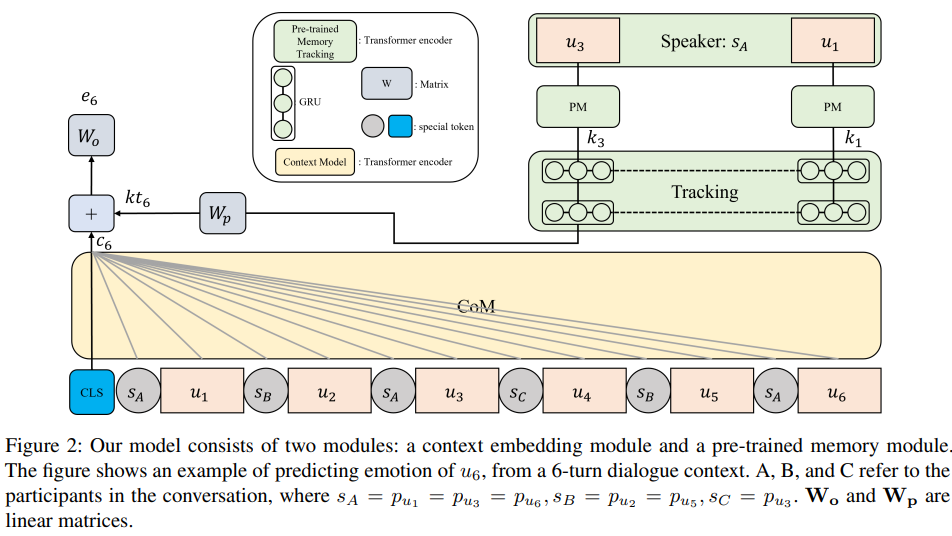

In [31]:
class MyDataset(Dataset):
    def __init__(self, data_path):
        f = open(data_path, 'r')
        rdr = csv.reader(f)

        """ 추가 """
        emoSet = set()
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

        """ 세션 데이터 저장할 것"""
        self.session_dataset = []
        session = []
        speaker_set = []

        """ 실제 데이터 저장 방식 """
        pre_sess = 'start'
        for i, line in enumerate(rdr):
            if i == 0:
                """ 저장할 데이터들 index 확인 """
                header  = line
                utt_idx = header.index('Utterance')
                speaker_idx = header.index('Speaker')
                emo_idx = header.index('Emotion')
                sess_idx = header.index('Dialogue_ID')
            else:
                utt = line[utt_idx]
                speaker = line[speaker_idx]
                """ 유니크한 스피커로 바꾸기 """
                if speaker in speaker_set:
                    uniq_speaker = speaker_set.index(speaker)
                else:
                    speaker_set.append(speaker)
                    uniq_speaker = speaker_set.index(speaker)
                emotion = line[emo_idx]
                sess = line[sess_idx]

                if pre_sess == 'start' or sess == pre_sess:
                    session.append([uniq_speaker, utt, emotion])
                else:
                    """ 세션 데이터 저장 """
                    self.session_dataset += data_split(session)
                    session = [[uniq_speaker, utt, emotion]]
                    speaker_set = []
                    emoSet.add(emotion)
                pre_sess = sess
        """ 마지막 세션 저장 """
        self.session_dataset += data_split(session)

        # self.emoList = sorted(emoSet) # 항상 같은 레이블 순서를 유지하기 위해
        self.emoList = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        f.close()

    def __len__(self): # 기본적인 구성
        return len(self.session_dataset)

    def __getitem__(self, idx): # 기본적인 구성
        return self.session_dataset[idx]

    def padding(self, batch_input_token): # batch size가 1보다 클 경우 추가
        """ 512 토큰 길이 넘으면 잘라내기 """
        batch_token_ids = batch_input_token['input_ids']
        batch_attention_masks = batch_input_token['attention_mask']

        trunc_batch_token_ids = []
        trunc_batch_attention_masks = []

        for batch_token_id, batch_attention_mask in zip(batch_token_ids, batch_attention_masks):
            if len(batch_token_id) > self.tokenizer.model_max_length:
                # 뒷부분 남기기
                trunc_batch_token_id = [batch_token_id[0]] + batch_token_id[1:][-self.tokenizer.model_max_length+1:]
                trunc_batch_attention_mask = [batch_attention_mask[0]] + batch_attention_mask[1:][-self.tokenizer.model_max_length+1:]

                trunc_batch_token_ids.append(trunc_batch_token_id)
                trunc_batch_attention_masks.append(trunc_batch_attention_mask)
            else:
                trunc_batch_token_ids.append(batch_token_id)
                trunc_batch_attention_masks.append(batch_attention_mask)

        """ padding token으로 패딩하기 """
        # [10, 30, 50] -> [50, 50, 50]
        # 50-10=40 , 50-30=20 : 패딩토큰으로 채운다. <pad>
        max_length = max([len(x) for x in trunc_batch_token_ids])
        padding_tokens = []
        padding_attention_masks = []
        for batch_token_id, batch_attention_mask in zip(trunc_batch_token_ids, trunc_batch_attention_masks):
            padding_tokens.append(batch_token_id + [self.tokenizer.pad_token_id for _ in range(max_length - len(batch_token_id))])
            padding_attention_masks.append(batch_attention_mask + [0 for _ in range(max_length - len(batch_token_id))])

        return torch.tensor(padding_tokens), torch.tensor(padding_attention_masks)

    def collate_fn(self, sessions): # 배치를 위한 구성
        '''
            input:
                data: [(session1), (session2), ... ]
            return:
                batch_input_tokens_pad: (B, L) padded
                batch_labels: (B)
        '''
        # [발화1, 발화2, ..., 발화8] 경우 발화 1보다 발화8이 더 중요하기에, 길이가 길어질 경우 [발화5...6...7...8]로 쓴다.

        """ 추가 """
        batch_input, batch_labels = [], []
        batch_PM_input = []
        for session in sessions:
            input_str = self.tokenizer.cls_token

            """ For PM """
            current_speaker, current_utt, current_emotion = session[-1]
            PM_input = []
            for i, line in enumerate(session):
                speaker, utt, emotion = line
                input_str += " " + utt + self.tokenizer.sep_token
                if i < len(session)-1 and current_speaker == speaker:
                    PM_input.append(self.tokenizer.encode(utt, add_special_tokens=True, return_tensors='pt'))
                    # [cls_token, tokens, sep_token]

            """ For CoM """
            batch_input.append(input_str)
            batch_labels.append(self.emoList.index(emotion))
            batch_PM_input.append(PM_input)
        batch_input_token = self.tokenizer(batch_input, add_special_tokens=False)
        batch_padding_token, batch_padding_attention_mask = self.padding(batch_input_token)

        return batch_padding_token, batch_padding_attention_mask, batch_PM_input, torch.tensor(batch_labels)

In [32]:
dev_dataset = MyDataset('./MELD/data/MELD/dev_sent_emo.csv')
dev_dataloader = DataLoader(dev_dataset, batch_size=3, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

In [49]:
for i, data in enumerate(dev_dataloader):
    if i == 1:
        print(data[1].shape)
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data

        print("batch_padding_token", batch_padding_token)
        print("batch_padding_attention_mask", batch_padding_attention_mask)
        print("batch_PM_input", batch_PM_input)
        print("batch_label", batch_label)
        break

torch.Size([3, 58])
batch_padding_token tensor([[    0,  1793,   328,  1793,     6,    52,   115,   213,     7,     5,
           827,     6,   593,    84,  2349,     8,   847,   106,   160,    23,
             5,  1300,     4,     2,   370,    17,    27,   241,    10, 16333,
           328,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    0,  1793,   328,  1793,     6,    52,   115,   213,     7,     5,
           827,     6,   593,    84,  2349,     8,   847,   106,   160,    23,
             5,  1300,     4,     2,   370,    17,    27,   241,    10, 16333,
           328,     2,    83, 33130,     6,   313,     6,   122,    52,   351,
            17,    27,    90,    28,   827, 30489,   328,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    0,  1793,   328,  1793,  